This notebook is how the *final* model was built. There were many iterations based on feature selection and model choice (including variations of clustering and PCA) but this one will go through:

- Graphlab's deep feature extraction for feature use
- Clustering for target variable selection
- One vs Rest SVC

### Load in the Data

In [6]:
#load in appropriate packages

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
import pickle
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import graphlab as gl
from sklearn.cross_validation import train_test_split

In [7]:
#load in the data

final = pd.read_csv("../data_pull_eda/final_pull.csv")
del final["Unnamed: 0"]
final.head()

,artistName,artworkUrl100,releaseDate,collectionName,decade,updated_genre,target
0,Admiral Bailey,http://is5.mzstatic.com/image/thumb/Music/v4/0...,1987-06-09T07:00:00Z,The Best of Admiral Bailey,1980.0,Reggae,Reggae-1980.0
1,Admiral Bailey,http://is3.mzstatic.com/image/thumb/Music/v4/0...,1988-01-01T08:00:00Z,Big Belly,1980.0,Reggae,Reggae-1980.0
2,Admiral Bailey,http://is4.mzstatic.com/image/thumb/Music/v4/3...,1987-06-09T07:00:00Z,Best of Admiral Bailey,1980.0,Reggae,Reggae-1980.0
3,Admiral Bailey,http://is5.mzstatic.com/image/thumb/Music/v4/2...,2006-06-24T07:00:00Z,Admiral Bailey's Turn Off the Heat - EP,2000.0,World,World-2000.0
4,Admiral Bailey,http://is5.mzstatic.com/image/thumb/Music/v4/8...,2011-06-20T07:00:00Z,Dela Move,2010.0,Reggae,Reggae-2010.0


In [8]:
#create pivot to identify how to sample

genre_decade = pd.pivot_table(final, index = ["updated_genre", "decade"], values = ["artistName"], aggfunc = len).unstack()
genre_decade

artistName                     
decade                1980.0 1990.0 2000.0 2010.0
updated_genre                                    
Alternative              401   1527   6718   7961
Blues                     13    112    545    406
Country                  202   1023   4098   4931
Dance                     91    686   7278  18717
Electronic                71    966   5275   8165
HipHop                    21    266   2444   4441
Jazz                      83    329   1481   1564
Pop                      277    889   4718   7438
RB Soul                   62    267   1167   1523
Reggae                   185    633   3233   6821
Rock                     576   1945   9243  10537
Singer/Songwriter         69    224   1094   1696
World                    118    567   2150   2176

In [4]:
#identify distribution of decades

genre_decade.sum()

            decade
artistName  1980.0     2169
            1990.0     9434
            2000.0    49444
            2010.0    76376
dtype: int64

In [47]:
#identify distribution of genre

genre_decade.T.sum().sort_values()

updated_genre
Blues                 1076
RB Soul               3019
Singer/Songwriter     3083
Jazz                  3457
World                 5011
HipHop                7172
Country              10254
Reggae               10872
Pop                  13322
Electronic           14477
Alternative          16607
Rock                 22301
Dance                26772
dtype: int64

### Rebalance the data


Given uneven count of decade and genres, pull sample of data each genre and decade for model use

In [38]:
#pull 1K of each of sample

decade_list = list(final["decade"].unique())

decade_samps = []
for i in decade_list:
    decade = final[final["decade"] == i].sample(n=1000, random_state = 77)
    decade_samps.append(decade)
    
decade_sample = pd.concat(decade_samps)


In [39]:
#check that it worked

decade_sample["decade"].value_counts()

2010.0    1000
2000.0    1000
1990.0    1000
1980.0    1000
Name: decade, dtype: int64

In [40]:
#check distro of genre - overrepresentation of rock and alternative

decade_sample["updated_genre"].value_counts()

Rock                 797
Alternative          580
Dance                498
Pop                  390
Electronic           380
Country              362
Reggae               305
World                166
HipHop               156
Jazz                 134
RB Soul              110
Singer/Songwriter     88
Blues                 34
Name: updated_genre, dtype: int64

In [41]:
#pull 800 of each of sample for genre

genre_list = list(final["updated_genre"].unique())

genre_samps = []
for i in genre_list:
    genre = final[final["updated_genre"] == i].sample(n=800, random_state = 77)
    genre_samps.append(genre)
genre_sample = pd.concat(genre_samps)

In [42]:
#check that it worked

genre_sample["updated_genre"].value_counts()

Country              800
Electronic           800
Blues                800
RB Soul              800
Rock                 800
Jazz                 800
Dance                800
Pop                  800
Reggae               800
Singer/Songwriter    800
World                800
HipHop               800
Alternative          800
Name: updated_genre, dtype: int64

In [43]:
#check distro of time period - over representation of latest decade

genre_sample["decade"].value_counts()

2010.0    5421
2000.0    3962
1990.0     839
1980.0     178
Name: decade, dtype: int64

### Train Test Split

In [44]:
#set the y variables for genre and decade  - included artist name as a checker to make sure decade and genre are right

y_genre = genre_sample[["artistName","updated_genre"]]
y_decade = decade_sample[["artistName", "decade"]]

In [46]:
#match up the image paths with whats in the y variable, since the features are the images

X_g_paths = ["./image/"+ str(i+1)+".jpg" for i in y_genre.index]
X_d_paths = ["./image/"+ str(i+1)+".jpg" for i in y_decade.index]

In [302]:
#train test split at 20% test size

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g_paths, y_genre, test_size = .20, random_state = 77)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d_paths, y_decade, test_size = .20, random_state = 77)

### Begin feature extraction

In [308]:
#set up the table for genre train set

#read in the genre train variables in a list
X_train_g_sf = [gl.Image(i) for i in X_train_g]

#resize all the items in list to 100 x 100
X_train_g_sf = [gl.image_analysis.resize(i, 100, 100, 3, decode=True) for i in X_train_g_sf]

#fit into a sframe
X_train_g_sf = gl.SFrame(X_train_g_sf)

#add columns for target variables
X_train_g_sf["labels"] = y_train_g["updated_genre"]
X_train_g_sf["artists"] = y_train_g["artistName"]

#ensure it worked
print X_train_g_sf

+------------------------+-------------------+-----------------------------+
|           X1           |       labels      |           artists           |
+------------------------+-------------------+-----------------------------+
| Height: 100 Width: 100 |       Reggae      |         Prince Far I        |
| Height: 100 Width: 100 |       Blues       | John Vosel & The Rock Jocks |
| Height: 100 Width: 100 |     Electronic    |    Blue Claw Philharmonic   |
| Height: 100 Width: 100 |       HipHop      |          Matt King          |
| Height: 100 Width: 100 |       Reggae      |          Alborosie          |
| Height: 100 Width: 100 |    Alternative    |          Limousine          |
| Height: 100 Width: 100 |    Alternative    | Black Rebel Motorcycle Club |
| Height: 100 Width: 100 |       World       |        Riyaaz Qawwali       |
| Height: 100 Width: 100 | Singer/Songwriter |        Woody Guthrie        |
| Height: 100 Width: 100 |       Blues       |       Various Artists       |

In [309]:
#repeat the process for genre test set

X_test_g_sf = [gl.Image(i) for i in X_test_g]
X_test_g_sf = [gl.image_analysis.resize(i, 100, 100, 3, decode=True) for i in X_test_g_sf]
X_test_g_sf = gl.SFrame(X_test_g_sf)
X_test_g_sf["labels"] = y_test_g["updated_genre"]
X_test_g_sf["artists"] = y_test_g["artistName"]
print X_test_g_sf

+------------------------+-------------------+------------------------+
|           X1           |       labels      |        artists         |
+------------------------+-------------------+------------------------+
| Height: 100 Width: 100 |      Country      | Nitty Gritty Dirt Band |
| Height: 100 Width: 100 |     Electronic    |      Multifaction      |
| Height: 100 Width: 100 |       Blues       |       Buddy Guy        |
| Height: 100 Width: 100 |        Jazz       | Lewis Winn & Jon Gagan |
| Height: 100 Width: 100 |       Blues       |      Curtis Jones      |
| Height: 100 Width: 100 |    Alternative    |       The Verve        |
| Height: 100 Width: 100 |      Country      |     Eddie Rabbitt      |
| Height: 100 Width: 100 | Singer/Songwriter |   Dodgy Mountain Men   |
| Height: 100 Width: 100 |        Jazz       |       Zoot Sims        |
| Height: 100 Width: 100 |       Dance       |      LeAnn Rimes       |
+------------------------+-------------------+------------------

In [312]:
#repeat the process for train decade set

X_train_d_sf = [gl.Image(i) for i in X_train_d]
X_train_d_sf = [gl.image_analysis.resize(i, 100, 100, 3, decode=True) for i in X_train_d_sf]
X_train_d_sf = gl.SFrame(X_train_d_sf)
X_train_d_sf["labels"] = y_train_d["decade"]
X_train_d_sf["artists"] = y_train_d["artistName"]

In [311]:
#repeat the process for test decade set

X_test_d_sf = [gl.Image(i) for i in X_test_d]
X_test_d_sf = [gl.image_analysis.resize(i, 100, 100, 3, decode=True) for i in X_test_d_sf]
X_test_d_sf = gl.SFrame(X_test_d_sf)
X_test_d_sf["labels"] = y_test_d["decade"]
X_test_d_sf["artists"] = y_test_d["artistName"]

In [313]:
#change decade labels to integers for processing purposes

X_test_d_sf["labels"] = X_test_d_sf["labels"].apply(lambda x: int(x))
X_train_d_sf["labels"] = X_train_d_sf["labels"].apply(lambda x: int(x))

In [22]:
#activate deep feature extractor - X1 is the column to pull features from

extractor = gl.feature_engineering.DeepFeatureExtractor(features = 'X1', model='auto')

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/imagenet_model_iter45/dir_archive.ini to /var/tmp/graphlab-katty/2559/1bab91a8-879a-46a3-a95f-6ed5c0a884e2.ini

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/imagenet_model_iter45/objects.bin to /var/tmp/graphlab-katty/2559/7a7f5edd-a8ad-487b-98f0-ea6d509ef033.bin

In [315]:
#pull deep features from genre train set

extractor_g_train = extractor.fit(X_train_g_sf)
features_g_train = extractor_g_train.transform(X_train_g_sf)
features_g_train

Images being resized.

X1,labels,artists,deep_features.X1
Height: 100 Width: 100,Reggae,Prince Far I,"[0.0, 0.0,0.0773056149483, 0.0, ..."
Height: 100 Width: 100,Blues,John Vosel & The RockJocks ...,"[0.0, 0.0, 0.0, 0.0,0.726023972034, ..."
Height: 100 Width: 100,Electronic,Blue Claw Philharmonic,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.925744056702, ..."
Height: 100 Width: 100,HipHop,Matt King,"[1.75639104843,0.410598576069, 0.0, ..."
Height: 100 Width: 100,Reggae,Alborosie,"[0.0, 0.0, 0.0, 0.0,0.366088330746, ..."
Height: 100 Width: 100,Alternative,Limousine,"[0.9176030159,1.45059657097, 0.0, 0.0, ..."
Height: 100 Width: 100,Alternative,Black Rebel MotorcycleClub ...,"[0.0, 0.107586205006,0.0, 0.544961094856, ..."
Height: 100 Width: 100,World,Riyaaz Qawwali,"[0.0, 0.0, 3.44681024551,1.53574752808, 0.0, ..."
Height: 100 Width: 100,Singer/Songwriter,Woody Guthrie,"[0.0, 0.0, 0.0, 0.0,0.276743888855, 0.0, ..."
Height: 100 Width: 100,Blues,Various Artists,"[0.0, 0.0, 0.0,0.495578765869, ..."


In [316]:
#pull deep features from genre test set

extractor_g_test = extractor.fit(X_test_g_sf)
features_g_test = extractor_g_test.transform(X_test_g_sf)
features_g_test

Images being resized.

X1,labels,artists,deep_features.X1
Height: 100 Width: 100,Country,Nitty Gritty Dirt Band,"[0.0, 0.0, 0.0,0.567603111267, ..."
Height: 100 Width: 100,Electronic,Multifaction,"[1.10145425797, 0.0, 0.0,0.0, 0.0, 0.0, ..."
Height: 100 Width: 100,Blues,Buddy Guy,"[0.267777621746,0.412346661091, 0.0, ..."
Height: 100 Width: 100,Jazz,Lewis Winn & Jon Gagan,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 7.07034301758, ..."
Height: 100 Width: 100,Blues,Curtis Jones,"[0.0, 0.0, 0.0, 0.0,0.232894778252, 0.0, ..."
Height: 100 Width: 100,Alternative,The Verve,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 6.7308382988, 0.0, ..."
Height: 100 Width: 100,Country,Eddie Rabbitt,"[0.0, 0.0, 0.0,1.64875125885, ..."
Height: 100 Width: 100,Singer/Songwriter,Dodgy Mountain Men,"[0.0, 0.0, 0.0, 0.0,0.800089001656, ..."
Height: 100 Width: 100,Jazz,Zoot Sims,"[0.0, 0.0, 0.0, 0.0,2.0701007843, 0.0, ..."
Height: 100 Width: 100,Dance,LeAnn Rimes,"[0.0, 0.0, 0.0, 0.0,2.51100301743, 0.0, ..."


In [320]:
#pull deep features from decade train set

extractor_d_train = extractor.fit(X_train_d_sf)
features_d_train = extractor_d_train.transform(X_train_d_sf)

Images being resized.

In [323]:
#pull deep features from decade test set

extractor_d_test = extractor.fit(X_test_d_sf)
features_d_test = extractor_d_test.transform(X_test_d_sf)

Images being resized.

### Set Up Clustering

Convert SFrame to Dataframe so that we could use SKlearn

In [11]:
#saved original sframes to csvs, and now am reading them in

df_g_train = pd.read_csv("features_g_train.csv")
df_d_train = pd.read_csv("features_d_train.csv")
df_d_test = pd.read_csv("features_d_test.csv")
df_g_test = pd.read_csv("features_g_test.csv")

In [12]:
#deep features converts to a string rather than a list when its saved as a csv
#replacing [] in lists and splitting on spaces

df_g_train["deep_features.X1"] = df_g_train["deep_features.X1"].apply(lambda x: x.replace("[", "").replace("]", "").split())
df_g_test["deep_features.X1"] = df_g_test["deep_features.X1"].apply(lambda x: x.replace("[", "").replace("]", "").split())
df_d_train["deep_features.X1"] = df_d_train["deep_features.X1"].apply(lambda x: x.replace("[", "").replace("]", "").split())
df_d_test["deep_features.X1"] = df_d_test["deep_features.X1"].apply(lambda x: x.replace("[", "").replace("]", "").split())

In [14]:
#converting each item into a float

def convertint(lizt):
    new_list = [float(i) for i in lizt]
    return new_list

df_g_train["deep_features.X1"] = df_g_train["deep_features.X1"].apply(convertint)
df_g_test["deep_features.X1"] = df_g_test["deep_features.X1"].apply(convertint)
df_d_train["deep_features.X1"] = df_d_train["deep_features.X1"].apply(convertint)
df_d_test["deep_features.X1"] = df_d_test["deep_features.X1"].apply(convertint)

In [15]:
#convert individual items in list of deep_features.X1 to individual columns

#done for genre train set

new_columns = []

for i in range(len(df_g_train)):
    columns = pd.Series(df_g_train["deep_features.X1"][i])
    new_columns.append(columns)

new_columns = pd.DataFrame(new_columns)
df_g_train_final = pd.concat([df_g_train, new_columns], axis = 1)

In [16]:
#done for genre test set

new_columns = []

for i in range(len(df_g_test)):
    columns = pd.Series(df_g_test["deep_features.X1"][i])
    new_columns.append(columns)

new_columns = pd.DataFrame(new_columns)
df_g_test_final = pd.concat([df_g_test, new_columns], axis = 1)

In [17]:
#done for genre train set

new_columns = []

for i in range(len(df_d_test)):
    columns = pd.Series(df_d_test["deep_features.X1"][i])
    new_columns.append(columns)

new_columns = pd.DataFrame(new_columns)
df_d_test_final = pd.concat([df_d_test, new_columns], axis = 1)

In [18]:
#done for decade train set

new_columns = []

for i in range(len(df_d_train)):
    columns = pd.Series(df_d_train["deep_features.X1"][i])
    new_columns.append(columns)

new_columns = pd.DataFrame(new_columns)
df_d_train_final = pd.concat([df_d_train, new_columns], axis = 1)

In [ ]:
#done for decade test set

new_columns = []

for i in range(len(df_d_test)):
    columns = pd.Series(df_d_test["deep_features.X1"][i])
    new_columns.append(columns)

new_columns = pd.DataFrame(new_columns)
df_d_test_final = pd.concat([df_d_test, new_columns], axis = 1)

In [27]:
#split into test/train split labels

df_y_train_g = df_g_train_final["labels"]
df_y_test_g = df_g_test_final["labels"]
df_X_train_g = df_g_train_final.iloc[:, 4:]
df_X_test_g = df_g_test_final.iloc[:, 4:]

df_y_train_d = df_d_train_final["labels"]
df_y_test_d = df_d_test_final["labels"]
df_X_train_d = df_d_train_final.iloc[:, 4:]
df_X_test_d = df_d_test_final.iloc[:, 4:]

Clustering using KMeans

In [56]:
#ran only against train set since clustering will be only used directionally

#cluster values were chosen based off of how many genres there were with the hope of rolling them together
k_test_g = [2,3,4,5,6,7,8,9,10,11,12,13]

for i in k_test_g:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_X_train_g)
    g_train_labels = kmeans.labels_
    print "this is kmeans silhouette score for genre", i, silhouette_score(df_X_train_g, g_train_labels)

#cluster values were chosen based off of how many decades there were with the hope of rolling them together
k_test_d = [2,3,4]
for i in k_test_d:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_X_train_d)
    d_train_labels = kmeans.labels_
    print "this is kmeans silhouette score for decade", i, silhouette_score(df_X_train_d, d_train_labels)

this is kmeans silhouette score for genre 2 0.0341786295815
this is kmeans silhouette score for genre 3 0.022147421303
this is kmeans silhouette score for genre 4 0.0249241304636
this is kmeans silhouette score for genre 5 0.0222942568298
this is kmeans silhouette score for genre 6 0.0221932708016
this is kmeans silhouette score for genre 7 0.0226278184803
this is kmeans silhouette score for genre 8 0.0204862338019
this is kmeans silhouette score for genre 9 0.0197201646874
this is kmeans silhouette score for genre 10 0.0202820560046
this is kmeans silhouette score for genre 11 0.0199230106162
this is kmeans silhouette score for genre 12 0.0193033457671
this is kmeans silhouette score for genre 13 0.0196414257777
this is kmeans silhouette score for decade 2 0.0343312249896
this is kmeans silhouette score for decade 3 0.0226945130562
this is kmeans silhouette score for decade 4 0.0252055920602


best performing # of clusters for decade and genre was 2. however, minimalizing to 2 genres doesn't make logical sense. further explored only 2 decades vs 2 genres

In [ ]:
#set kmeans to 2 clusters for the train set for decades

kmeans_d = KMeans(n_clusters=2)
kmeans_d.fit(df_X_train_d)
d_train_labels = kmeans_d.labels_

In [70]:
#append the labels to the list and see which ones are which

df_d_train_final["kmeans"] = d_train_labels

In [98]:
#see the distribution of decades by cluster

cluster_d = df_d_train_final.groupby(["kmeans", "labels"])["kmeans"].count().to_frame("Count").reset_index()

this is decade by label  0
this is decade by label  1


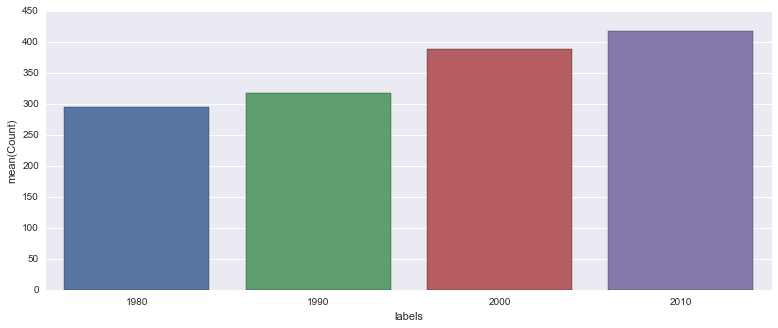

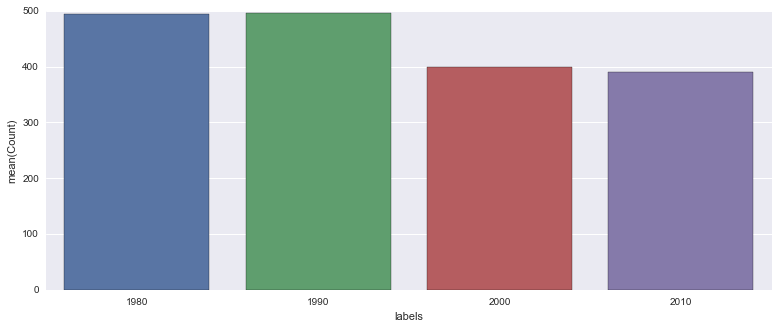

In [115]:
#plot the distribution of the clusters

for i in cluster_d["kmeans"].unique():
    plt.figure(figsize=(13,5))
    ax = sns.barplot(x="labels", y="Count", data=cluster_d[cluster_d["kmeans"] == i])
    print "this is decade by label ", i

shows directional overconcentration of decades in each label - will use two targets for decade vs 4 from now on

In [4]:
#set new labels for the decade targets to before 1980 and after 1990

df_ydecade_train_d = df_y_train_d.apply(lambda x: "1980 to 2000" if x == 1980 or x == 1990 else "2000 to Present")
df_ydecade_test_d = df_y_test_d.apply(lambda x: "1980 to 2000" if x == 1980 or x == 1990 else "2000 to Present")

### Implement SVM

In [ ]:
#implement gridsearch for decade

from sklearn import grid_search
parameters = {'estimator__kernel':['linear', 'rbf', 'poly'], 'estimator__C':[0.01, 0.1, 1, 10, 100]}

estimatorz = OneVsRestClassifier(SVC())

gv_d_model = grid_search.GridSearchCV(estimatorz, param_grid = parameters, n_jobs=-1)
gv_d_model.fit(df_X_train_d, df_ydecade_train_d)
print "Best Params Decade:", gv_d_model.best_params_
print "Best Score Decade:", gv_d_model.best_score_


Best Params Decade: {'estimator__kernel': 'poly', 'estimator__C': 1}
Best Score Decade: 0.6365625


In [26]:
#attempt same genre - C values actually don't make a difference so will fit only on kernels

kernel_list = ['rbf', 'poly']

for i in kernel_list:
    classif = OneVsRestClassifier(SVC(kernel=i))
    svm_g_model = classif.fit(df_X_train_g, df_y_train_g)
    svm_g_predict = svm_g_model.predict(df_X_test_g)
    print "this is genre ", i,  accuracy_score(df_y_test_g, svm_g_predict)

 this is genre  rbf 0.264423076923
this is genre  poly 0.271153846154


In [7]:
#final model so can run confusion matrix

classif_d = OneVsRestClassifier(SVC(kernel='poly', C = 1, probability=True))
svm_ddecade_model = classif_d.fit(df_X_train_d, df_ydecade_train_d)
svm_ddecade_predict = svm_ddecade_model.predict(df_X_test_d)

classif = OneVsRestClassifier(SVC(kernel="poly", probability=True))
svm_g_model = classif.fit(df_X_train_g, df_y_train_g)
svm_g_predict = svm_g_model.predict(df_X_test_g)

In [22]:
#print confusion matrix for genre

g_cm = confusion_matrix(df_y_test_g, svm_g_predict, labels = svm_g_model.classes_)
g_cm = pd.DataFrame(g_cm, columns = svm_g_model.classes_, index = svm_g_model.classes_)
g_cm

,Alternative,Blues,Country,Dance,Electronic,HipHop,Jazz,Pop,RB Soul,Reggae,Rock,Singer/Songwriter,World
Alternative,27,12,3,7,21,11,7,7,7,5,13,15,18
Blues,7,73,13,5,5,7,11,7,13,10,10,6,9
Country,7,15,41,3,7,5,6,9,16,13,4,5,8
Dance,7,6,9,52,12,8,6,9,9,12,8,7,16
Electronic,15,4,3,23,37,15,12,6,4,10,12,7,14
HipHop,12,14,12,14,9,44,7,5,18,15,12,3,8
Jazz,11,16,13,7,10,9,35,6,13,10,5,5,15
Pop,12,10,24,16,9,17,8,28,13,6,9,7,5
RB Soul,3,6,21,11,6,6,10,12,49,17,1,5,7
Reggae,7,8,6,11,7,11,10,7,9,70,6,6,8


[[27 12  3  7 21 11  7  7  7  5 13 15 18]
 [ 7 73 13  5  5  7 11  7 13 10 10  6  9]
 [ 7 15 41  3  7  5  6  9 16 13  4  5  8]
 [ 7  6  9 52 12  8  6  9  9 12  8  7 16]
 [15  4  3 23 37 15 12  6  4 10 12  7 14]
 [12 14 12 14  9 44  7  5 18 15 12  3  8]
 [11 16 13  7 10  9 35  6 13 10  5  5 15]
 [12 10 24 16  9 17  8 28 13  6  9  7  5]
 [ 3  6 21 11  6  6 10 12 49 17  1  5  7]
 [ 7  8  6 11  7 11 10  7  9 70  6  6  8]
 [17 12  7  5 10 10  6  8 10 11 23 14 16]
 [ 9  9 15  6 13 13 11  5  9  7  6 35 14]
 [ 6 16 10 10 11  8 10  7  9 14  8 17 50]]


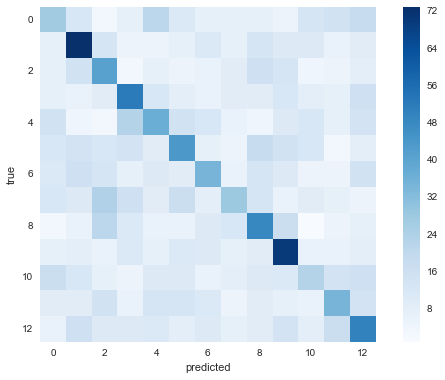

In [27]:
# more illustrative version of genre

from sklearn.metrics import confusion_matrix
genrelabels = list(svm_g_model.classes_)

fig, ax = plt.subplots(figsize=(10,6))
print(confusion_matrix(df_y_test_g, svm_g_predict, labels = svm_g_model.classes_))
plt.imshow(confusion_matrix(df_y_test_g, svm_g_predict, labels = svm_g_model.classes_),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [31]:
#check classification report for genre

print classification_report(df_y_test_g, svm_g_predict)

             precision    recall  f1-score   support

Alternative       0.19      0.18      0.18       153
      Blues       0.36      0.41      0.39       176
    Country       0.23      0.29      0.26       139
      Dance       0.31      0.32      0.31       161
 Electronic       0.24      0.23      0.23       162
     HipHop       0.27      0.25      0.26       173
       Jazz       0.25      0.23      0.24       155
        Pop       0.24      0.17      0.20       164
    RB Soul       0.27      0.32      0.29       154
     Reggae       0.35      0.42      0.38       166
       Rock       0.20      0.15      0.17       149
Singer/Songwriter       0.27      0.23      0.25       152
      World       0.27      0.28      0.27       176

avg / total       0.27      0.27      0.27      2080



[[258 138]
 [137 267]]


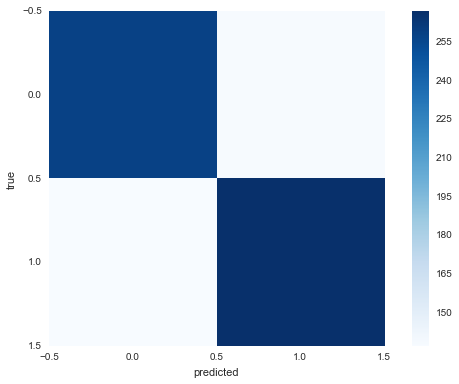

In [19]:
#check for decade

fig, ax = plt.subplots(figsize=(10,6))
print(confusion_matrix(df_ydecade_test_d, svm_ddecade_predict, labels = svm_ddecade_model.classes_))
plt.imshow(confusion_matrix(df_ydecade_test_d, svm_ddecade_predict, labels = svm_ddecade_model.classes_),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [30]:
#check for decade

from sklearn.metrics import classification_report

print classification_report(df_ydecade_test_d, svm_ddecade_predict)

             precision    recall  f1-score   support

1980 to 2000       0.65      0.65      0.65       396
2000 to Present       0.66      0.66      0.66       404

avg / total       0.66      0.66      0.66       800

